In [1]:
import glob
import io
import os
import mediapy as media
import numpy as np
from PIL import Image
from PIL import Image
import tensorflow_text
from tips.pytorch import image_encoder
from tips.pytorch import text_encoder
from tips.scenic.utils import feature_viz
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import transforms

2025-03-27 14:10:02.527205: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743102602.647986   60463 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743102602.690557   60463 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-27 14:10:03.233020: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/usr/mvl2/jdmcnw/Projects/2025/VOTS/TIPS/tips/pytorch/image_encoder.py:175: UserWarning: xFormers is not available (SwiGLU)
 

In [2]:
model_image = image_encoder.vit_small(
    img_size=448,
    patch_size=14,
    ffn_layer='mlp',
    block_chunks=0,
    init_values=1.0,
    interpolate_antialias=True,
    interpolate_offset=0.0,
)

In [3]:

# Add the checkpoints and tokenizer path.
image_encoder_checkpoint = '/usr/mvl2/jdmcnw/Projects/2025/VOTS/TIPS/tips/pytorch/checkpoints/tips_oss_s14_highres_distilled_vision.npz'  # @param {type: "string"}
text_encoder_checkpoint = '/usr/mvl2/jdmcnw/Projects/2025/VOTS/TIPS/tips/pytorch/checkpoints/tips_oss_s14_highres_distilled_text.npz'  # @param {type: "string"}
tokenizer_path = '/usr/mvl2/jdmcnw/Projects/2025/VOTS/TIPS/tips/pytorch/checkpoints/tokenizer.model'  # @param {type: "string"}

In [4]:
# Load checkpoint.
# Set the input image shape and variant.
image_size = 448  # @param {type: "number"}
variant = 'S'  # @param ['S', 'B', 'L', 'So400m', 'g']

weights_image = dict(np.load(image_encoder_checkpoint, allow_pickle=False))
for key in weights_image:
  weights_image[key] = torch.tensor(weights_image[key])
ffn_layer = 'swiglu' if variant == 'g' else 'mlp'

embeddings_image, spatial_features = [], []


In [5]:
# Set the input image shape and variant.
image_size = 448  # @param {type: "number"}
variant = 'S'  # @param ['S', 'B', 'L', 'So400m', 'g']


IMAGE_MEAN = (0, 0, 0)
IMAGE_STD = (1.0, 1.0, 1.0)
PATCH_SIZE = 14
MAX_LEN = 64
VOCAB_SIZE = 32000

# Add your images in this directory.
image_dir = 'images/inputs/basketball/color/'  # @param {type: "string"}
image_paths = glob.glob(os.path.join(image_dir, '*'))[:1]
# The text inputs to be contrasted.
text_inputs = [
    'A ship',
    'A lion',
    'a toy',
    'Seven Cats',
    'A laptop',
    'a cat',
    'a starry night',
    'A president',
]


In [6]:
# Load checkpoint.
weights_image = dict(np.load(image_encoder_checkpoint, allow_pickle=False))
for key in weights_image:
  weights_image[key] = torch.tensor(weights_image[key])
ffn_layer = 'swiglu' if variant == 'g' else 'mlp'

embeddings_image, spatial_features = [], []


def load_image_bytes(file_name):
  with open(file_name, 'rb') as fd:
    image_bytes = io.BytesIO(fd.read())
    pil_image = Image.open(image_bytes)
    transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize(IMAGE_MEAN, IMAGE_STD),
    ])
    input_tensor = transform(pil_image)
    input_batch = input_tensor.unsqueeze(0)

  return input_batch

with torch.no_grad():
  # Load the vision encoder.
  model_image = image_encoder.vit_small(
      img_size=image_size,
      patch_size=PATCH_SIZE,
      ffn_layer=ffn_layer,
      block_chunks=0,
      init_values=1.0,
      interpolate_antialias=True,
      interpolate_offset=0.0,
  )
  model_image.load_state_dict(weights_image)

  for image_path in image_paths:
    input_batch = load_image_bytes(image_path)
    output = model_image(input_batch)
    cls_token = feature_viz.normalize(
        output[0][0][0]
    )  # Choose the first CLS token.
    spatial_feature = torch.reshape(
        output[2],
        (1, int(image_size / PATCH_SIZE), int(image_size / PATCH_SIZE), -1),
    )
    spatial_features.append(spatial_feature)
    embeddings_image.append(cls_token)

In [7]:


model_image.eval()


VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0-11): 12 x Block(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): MemEffAttention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=1536, out_features=384, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
      (ls2): LayerScale()
      (drop_path2): Identity()
    )
  )
  (norm): LayerNorm(

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ReassembleLayer(nn.Module):
    def __init__(self, in_channels, out_channels, scale_factor):
        super().__init__()
        self.proj = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.upsample = nn.Upsample(scale_factor=scale_factor, mode='bilinear', align_corners=False)

    def forward(self, x):
        x = self.proj(x)
        x = self.upsample(x)
        return x


class FusionBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels, channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x, skip):
        x = F.interpolate(x, size=skip.shape[2:], mode='bilinear', align_corners=False)
        x = x + skip
        return self.conv(x)


class TextFusion(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.fc = nn.Linear(dim, dim)  # Now this uses actual cls_token dim

    def forward(self, feat_map, cls_token):
        t = self.fc(cls_token).unsqueeze(-1).unsqueeze(-1)  # [B, D, 1, 1]
        return feat_map * (1 + t)



class TIPSDecoderDPT(nn.Module):
    def __init__(self, in_channels=768, mid_channels=256, use_cls_token=True):
        super().__init__()
        self.use_cls_token = use_cls_token

        # Reassemble features to 4 resolutions
        self.reassemble_layers = nn.ModuleList([
            ReassembleLayer(in_channels, mid_channels, scale_factor=1),  # 32x32
            ReassembleLayer(in_channels, mid_channels, scale_factor=2),  # 64x64
            ReassembleLayer(in_channels, mid_channels, scale_factor=4),  # 128x128
            ReassembleLayer(in_channels, mid_channels, scale_factor=8),  # 256x256
        ])

        # Fusion stages
        self.fusion_blocks = nn.ModuleList([
            FusionBlock(mid_channels),
            FusionBlock(mid_channels),
            FusionBlock(mid_channels),
            FusionBlock(mid_channels),
        ])

        # Optional text fusion using CLS token
        if self.use_cls_token:
            self.text_fusion = TextFusion(in_channels)


        # Depth output head
        self.depth_head = nn.Sequential(
            nn.Conv2d(mid_channels, mid_channels // 2, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.Conv2d(mid_channels // 2, 1, kernel_size=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=14, mode='bilinear', align_corners=False)  # 32 × 14 = 448
        )



        # Normals output head
        self.normals_head = nn.Sequential(
            nn.Conv2d(mid_channels, mid_channels // 2, kernel_size=3, padding=1),
            nn.ReLU(True),
            nn.Conv2d(mid_channels // 2, 3, kernel_size=1),
            nn.Tanh(),
            nn.Upsample(scale_factor=14, mode='bilinear', align_corners=False)  # 32×14 = 448
        )


    def forward(self, spatial_features, cls_token=None):
        """
        spatial_features: [B, D, H, W] from TIPS (e.g., [B, 768, 32, 32])
        cls_token: [B, D], optional global embedding (from TIPS CLS)
        """

        # Reassemble to multi-resolution features
        feats = []
        for reassemble in self.reassemble_layers:
            feats.append(reassemble(spatial_features))

        # Bottom-up fusion
        x = feats[-1]  # Start from lowest-res
        for i in range(3, -1, -1):
            x = self.fusion_blocks[3 - i](x, feats[i])

        # Optional scene-aware conditioning
        if self.use_cls_token and cls_token is not None:
            x = self.text_fusion(x, cls_token)

        # Heads
        depth = self.depth_head(x)
        normals = self.normals_head(x)

        return depth, normals

In [9]:

decoder = TIPSDecoderDPT(in_channels=384, mid_channels=256, use_cls_token=True).cuda()

In [10]:
def prepare_decoder_inputs(spatial_feature, cls_token):
    """
    Convert raw TIPS outputs to decoder-ready inputs.

    Args:
        spatial_feature: torch.Tensor of shape [1, H, W, D]
        cls_token: torch.Tensor of shape [D] or [1, D]

    Returns:
        spatial_feature: [1, D, H, W]
        cls_token: [1, D]
    """
    if spatial_feature.ndim == 4 and spatial_feature.shape[1] != spatial_feature.shape[-1]:
        spatial_feature = spatial_feature.permute(0, 3, 1, 2).contiguous()

    if cls_token.ndim == 1:
        cls_token = cls_token.unsqueeze(0)

    return spatial_feature.cuda(), cls_token.cuda()


In [11]:
# Later on, when you're ready to use a sample:
raw_spatial = spatial_features[0]     # [1, H, W, D]
raw_cls = embeddings_image[0]         # [D]

# Convert to decoder input
x, cls = prepare_decoder_inputs(raw_spatial, raw_cls)

In [12]:
decoder = TIPSDecoderDPT(in_channels=384, mid_channels=384).cuda()


In [13]:
depth, normals = decoder(x, cls)

In [14]:
depth.shape

torch.Size([1, 1, 448, 448])

In [15]:
normals.shape

torch.Size([1, 3, 448, 448])

In [16]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF

def show_depth_map(depth_tensor):
    depth_np = depth_tensor.squeeze().detach().cpu().numpy()  # [H, W]
    
    # Normalize to 0-1 for visualization
    depth_min = depth_np.min()
    depth_max = depth_np.max()
    depth_norm = (depth_np - depth_min) / (depth_max - depth_min + 1e-8)

    plt.figure(figsize=(6, 6))
    plt.imshow(depth_norm, cmap='gray_r')
    plt.colorbar(label='Normalized Depth')
    plt.title('Predicted Depth')
    plt.axis('off')
    plt.show()


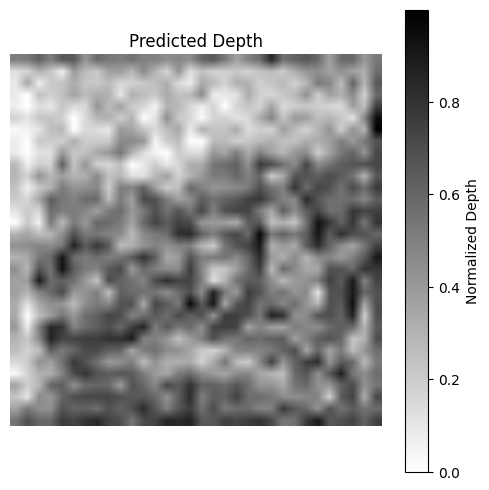

In [17]:
show_depth_map(depth)

In [18]:
def show_normal_map(normals_tensor):
    normals_np = normals_tensor.squeeze().permute(1, 2, 0).detach().cpu().numpy()  # [H, W, 3]
    
    # Convert from [-1, 1] to [0, 1] for display
    normals_rgb = (normals_np + 1.0) / 2.0
    normals_rgb = normals_rgb.clip(0, 1)

    plt.figure(figsize=(6, 6))
    plt.imshow(normals_rgb)
    plt.title('Predicted Surface Normals')
    plt.axis('off')
    plt.show()


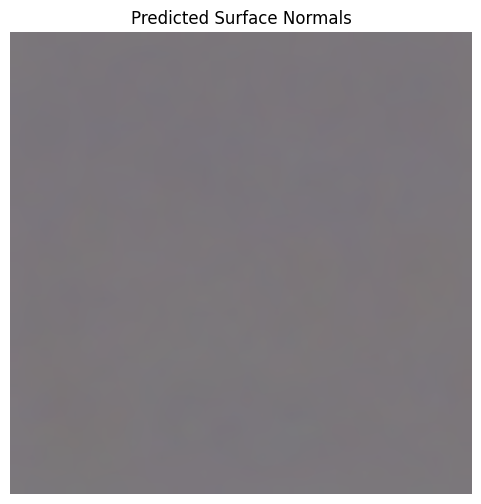

In [19]:
show_normal_map(normals)

##  Training DPT

In [20]:
#!pip install kagglehub

In [21]:
#import kagglehub

# Download latest version
#path = kagglehub.dataset_download("soumikrakshit/nyu-depth-v2")

#print("Path to dataset files:", path)

In [22]:
#!pip install torchmetrics

In [23]:
######### 

In [24]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.cuda.amp import GradScaler, autocast
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from pathlib import Path
import cv2 as cv
from PIL import Image

from sklearn.model_selection import train_test_split
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchmetrics.image import StructuralSimilarityIndexMeasure as SSIM
from torchmetrics.regression import MeanSquaredError as MSE
from torchmetrics.collections import MetricCollection
import gc
from torchvision.transforms import Normalize

In [25]:
#import torch.multiprocessing as mp
#mp.set_start_method('spawn', force=True)


In [26]:
train_csv = Path('/usr/mvl2/jdmcnw/.cache/kagglehub/datasets/soumikrakshit/nyu-depth-v2/versions/1/nyu_data/data/nyu2_train.csv')
train_ims_path = Path('/usr/mvl2/jdmcnw/.cache/kagglehub/datasets/soumikrakshit/nyu-depth-v2/versions/1/nyu_data/data/nyu2_train')
base_path = Path('/usr/mvl2/jdmcnw/.cache/kagglehub/datasets/soumikrakshit/nyu-depth-v2/versions/1/nyu_data')


df = pd.read_csv(train_csv,header=None)
df[0] = df[0].map(lambda x:base_path/x)
df[1] = df[1].map(lambda x:base_path/x)
df.head()

train_df, val_df = train_test_split(df,test_size=0.1,shuffle=True)
val_df, test_df = train_test_split(val_df, test_size=0.1,shuffle=True)
train_df.reset_index(drop=True,inplace=True)
val_df.reset_index(drop=True,inplace=True)
test_df.reset_index(drop=True,inplace=True)
train_df=train_df[0:10000]
val_df=val_df[0:1000]
len(train_df),len(val_df), len(test_df)

(10000, 1000, 507)

In [27]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class NYUv2TIPSDataset(Dataset):
    def __init__(self, dataframe, image_size, tips_encoder, transform=None):
        self.df = dataframe
        self.image_size = image_size
        self.device = device  # <- reusing global device
        self.encoder = tips_encoder.to(self.device).eval()
        self.transform = transform or transforms.Compose([
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor(),
            transforms.Normalize((0, 0, 0), (1, 1, 1))
        ])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        rgb_path, depth_path = self.df.iloc[idx]
        image = Image.open(rgb_path).convert('RGB')
        depth = Image.open(depth_path)

        # Transform inputs
        image = self.transform(image).to(self.device)  # <- move image to encoder's device
        depth = transforms.Resize((256, 256))(depth)
        depth = transforms.ToTensor()(depth)

        with torch.no_grad():
            features = self.encoder(image.unsqueeze(0))[2]  # spatial patch tokens [1, HW, D]
            B, HW, D = features.shape
            spatial = features.view(1, int(HW ** 0.5), int(HW ** 0.5), D).permute(0, 3, 1, 2).squeeze(0)

        return spatial, depth


In [28]:
# This file implements a DPT-style decoder using frozen TIPS encoder features.

import torch
import torch.nn as nn
import torch.nn.functional as F


class ReassembleLayer(nn.Module):
    def __init__(self, in_channels, out_channels, scale_factor):
        super().__init__()
        self.project = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        self.scale_factor = scale_factor
        self.resample = nn.Upsample(scale_factor=scale_factor, mode='bilinear', align_corners=False)

    def forward(self, x):
        x = self.project(x)
        x = self.resample(x)
        return x


class FusionBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.residual_conv = nn.Sequential(
            nn.Conv2d(channels, channels, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels, channels, 3, padding=1),
            nn.ReLU(inplace=True)
        )
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)

    def forward(self, x, skip):
        # Resize skip if needed
        if x.shape[-2:] != skip.shape[-2:]:
            skip = F.interpolate(skip, size=x.shape[-2:], mode='bilinear', align_corners=False)
        x = self.residual_conv(x + skip)
        x = self.upsample(x)
        return x



class DPTDepthDecoder(nn.Module):
    def __init__(self, embed_dim=384, channels=256):
        super().__init__()
        self.reassemble_layers = nn.ModuleList([
            ReassembleLayer(embed_dim, channels, scale_factor=4),   # 32x32 -> 128x128
            ReassembleLayer(embed_dim, channels, scale_factor=2),   # 32x32 -> 64x64
            ReassembleLayer(embed_dim, channels, scale_factor=1),   # 32x32 -> 32x32
        ])

        self.fusion_blocks = nn.ModuleList([
            FusionBlock(channels),
            FusionBlock(channels),
        ])

        self.output_head = nn.Sequential(
            nn.Conv2d(channels, channels // 2, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels // 2, 1, 1)
        )

    def forward(self, spatial_feats):
        feats = [layer(spatial_feats) for layer in self.reassemble_layers]
        x = feats[-1]  # lowest res (32x32)
        x = self.fusion_blocks[0](x, feats[-2])  # 64x64
        x = self.fusion_blocks[1](x, feats[-3])  # 128x128
        depth = self.output_head(x)             # 128x128
        depth = F.interpolate(depth, scale_factor=2, mode='bilinear', align_corners=False)  # 256x256
        return depth


In [29]:
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn as nn

# Assume: `decoder` is DPTDepthDecoder, `tips_encoder` is frozen model_image from earlier
train_dataset = NYUv2TIPSDataset(train_df, image_size=448, tips_encoder=model_image)


train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True,  num_workers=0)

decoder = DPTDepthDecoder(embed_dim=384, channels=256).cuda()
criterion = nn.MSELoss()
optimizer = optim.Adam(decoder.parameters(), lr=1e-4)


In [30]:
import torch
from tqdm import tqdm
import time

# Make sure this is set earlier in your notebook/script
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
decoder = decoder.to(device)

print(f"✅ Using device: {device}")
num_epochs = 10

for epoch in range(num_epochs):
    decoder.train()
    total_loss = 0
    start_time = time.time()

    loop = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch}")

    for i, (features, gt_depth) in loop:
        # ⬅ Move inputs to device
        features = features.to(device)
        gt_depth = gt_depth.to(device)

        # Optional: print shape on first iteration
        if epoch == 0 and i == 0:
            print(f" ➤ Features: {features.shape}, Depth GT: {gt_depth.shape}")

        # Training step
        optimizer.zero_grad()
        pred_depth = decoder(features)
        loss = criterion(pred_depth, gt_depth)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        loop.set_postfix(batch_loss=loss.item())

    # Epoch summary
    avg_loss = total_loss / len(train_loader)
    duration = time.time() - start_time
    print(f"✅ Epoch {epoch} completed | Avg Loss: {avg_loss:.4f} | Time: {duration:.2f} sec")


✅ Using device: cuda


Epoch 0:   0%|          | 0/1250 [00:00<?, ?it/s]

 ➤ Features: torch.Size([8, 384, 32, 32]), Depth GT: torch.Size([8, 1, 256, 256])


Epoch 0: 100%|██████████| 1250/1250 [07:16<00:00,  2.86it/s, batch_loss=0.0031] 


✅ Epoch 0 completed | Avg Loss: 0.0045 | Time: 436.46 sec


Epoch 1: 100%|██████████| 1250/1250 [05:25<00:00,  3.84it/s, batch_loss=0.00282] 


✅ Epoch 1 completed | Avg Loss: 0.0027 | Time: 325.17 sec


Epoch 2: 100%|██████████| 1250/1250 [04:48<00:00,  4.33it/s, batch_loss=0.00194] 


✅ Epoch 2 completed | Avg Loss: 0.0022 | Time: 288.48 sec


Epoch 3: 100%|██████████| 1250/1250 [04:31<00:00,  4.61it/s, batch_loss=0.0023]  


✅ Epoch 3 completed | Avg Loss: 0.0019 | Time: 271.13 sec


Epoch 4: 100%|██████████| 1250/1250 [04:28<00:00,  4.65it/s, batch_loss=0.000785]


✅ Epoch 4 completed | Avg Loss: 0.0017 | Time: 268.91 sec


Epoch 5: 100%|██████████| 1250/1250 [04:29<00:00,  4.63it/s, batch_loss=0.0019]  


✅ Epoch 5 completed | Avg Loss: 0.0015 | Time: 269.90 sec


Epoch 6: 100%|██████████| 1250/1250 [04:42<00:00,  4.43it/s, batch_loss=0.00153] 


✅ Epoch 6 completed | Avg Loss: 0.0014 | Time: 282.48 sec


Epoch 7: 100%|██████████| 1250/1250 [04:35<00:00,  4.54it/s, batch_loss=0.00103] 


✅ Epoch 7 completed | Avg Loss: 0.0013 | Time: 275.28 sec


Epoch 8: 100%|██████████| 1250/1250 [04:32<00:00,  4.59it/s, batch_loss=0.0015]  


✅ Epoch 8 completed | Avg Loss: 0.0012 | Time: 272.43 sec


Epoch 9: 100%|██████████| 1250/1250 [04:30<00:00,  4.62it/s, batch_loss=0.00106] 

✅ Epoch 9 completed | Avg Loss: 0.0011 | Time: 270.35 sec


save_path = f"checkpoints/dpt_decoder_epoch_{epoch}.pth"
torch.save(decoder.state_dict(), save_path)
print(f"💾 Saved decoder weights to {save_path}")


# Saving the model

import os
os.makedirs("checkpoints", exist_ok=True)


In [31]:
#decoder = DPTDepthDecoder(embed_dim=384, channels=256)
#decoder.load_state_dict(torch.load("checkpoints/dpt_decoder_epoch_1.pth"))
#decoder = decoder.to(device)
#decoder.eval()

#if val_loss < best_val_loss:
#    best_val_loss = val_loss
#    torch.save(decoder.state_dict(), "checkpoints/best_decoder.pth")


# Validation

In [32]:
val_dataset = NYUv2TIPSDataset(val_df, image_size=448, tips_encoder=model_image)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=0)


In [33]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_depth_predictions(rgb_paths, preds, gts, n=4):
    for i in range(min(n, len(preds))):
        plt.figure(figsize=(12, 4))
        
        # Input RGB
        plt.subplot(1, 3, 1)
        img = Image.open(rgb_paths[i]).resize((256, 256))
        plt.imshow(img)
        plt.title("RGB Input")
        plt.axis("off")
        
        # Predicted Depth
        plt.subplot(1, 3, 2)
        plt.imshow(preds[i].squeeze(), cmap='inferno')
        plt.title("Predicted Depth")
        plt.axis("off")
        
        # Ground Truth Depth
        plt.subplot(1, 3, 3)
        plt.imshow(gts[i].squeeze(), cmap='inferno')
        plt.title("Ground Truth Depth")
        plt.axis("off")
        
        plt.tight_layout()
        plt.show()


In [34]:
from sklearn.metrics import mean_squared_error

decoder.eval()
all_preds, all_gts, all_rgb_paths = [], [], []

with torch.no_grad():
    for idx, (features, gt_depth) in enumerate(val_loader):
        features, gt_depth = features.to(device), gt_depth.to(device)
        preds = decoder(features)

        all_preds.append(preds.cpu())
        all_gts.append(gt_depth.cpu())

        # Save RGB paths to visualize later
        batch_paths = [str(val_df.iloc[i + idx * val_loader.batch_size, 0]) for i in range(len(features))]
        all_rgb_paths.extend(batch_paths)

        if idx >= 2: break  # Limit to a few batches for sanity check

all_preds = torch.cat(all_preds)
all_gts = torch.cat(all_gts)


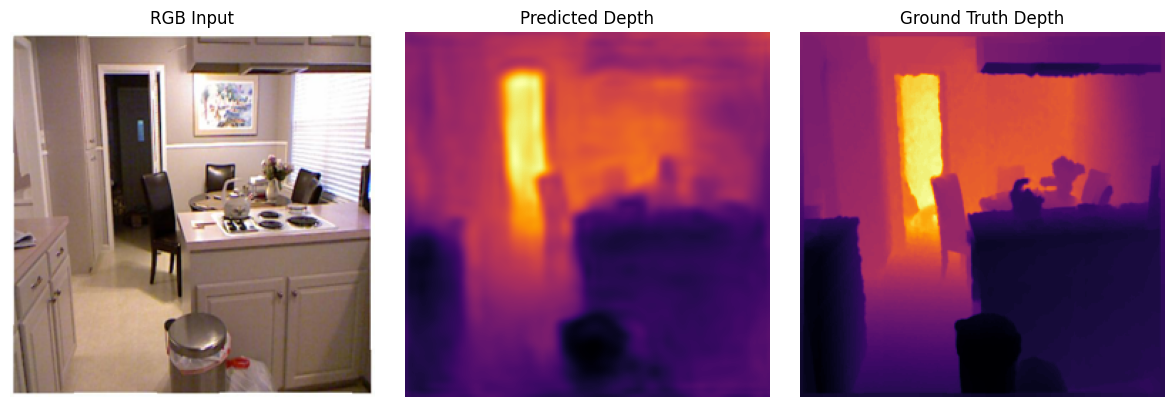

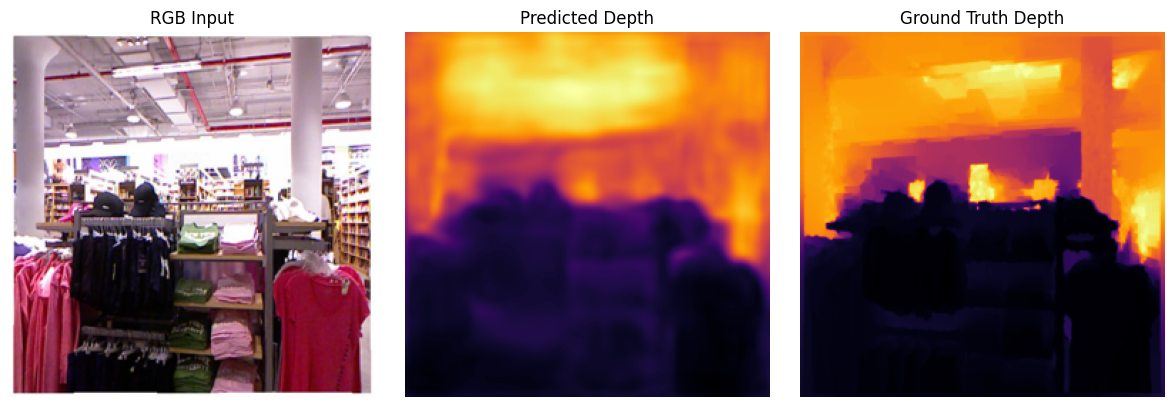

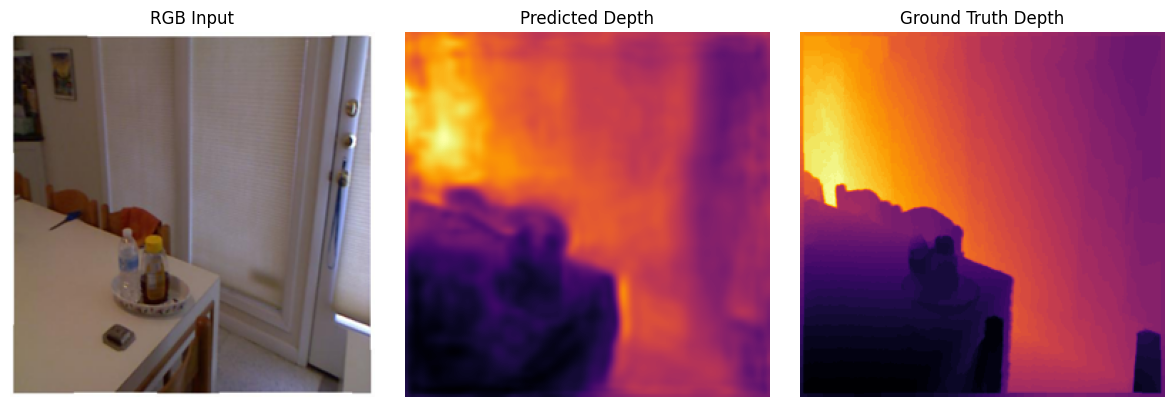

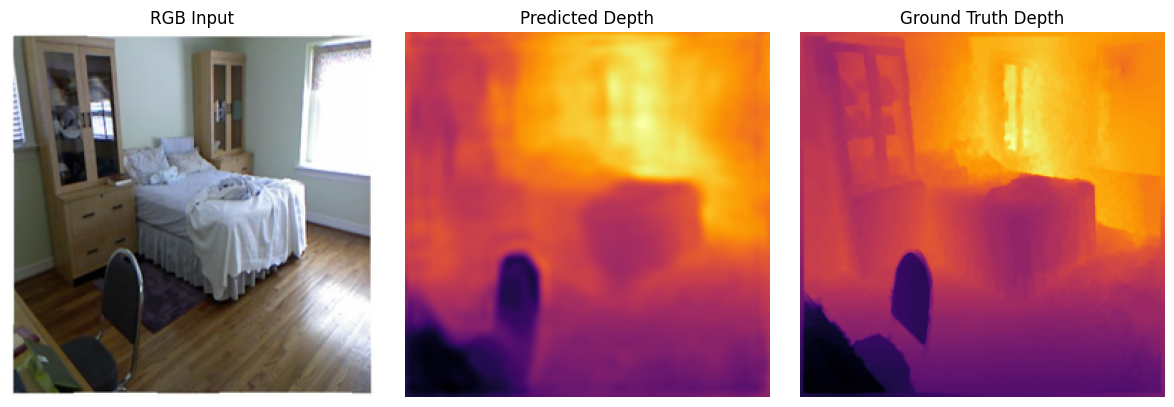

In [35]:
visualize_depth_predictions(all_rgb_paths, all_preds, all_gts, n=4)


In [36]:
def compute_rmse(pred, gt):
    return torch.sqrt(torch.mean((pred - gt) ** 2)).item()

rmse_val = compute_rmse(all_preds, all_gts)
print(f"🔎 RMSE (Validation, few batches): {rmse_val:.4f}")


🔎 RMSE (Validation, few batches): 0.0395
